In [100]:
import pandas as pd
import seaborn as sns
import statannot
import matplotlib as mpl
import re

In [28]:
pd.options.display.max_rows = 100

Read ACE2 Exon9 and Exon9a counts

In [29]:
data = pd.read_table("short_ace2.txt")

Manual group assignment of samples

In [30]:
fdel508 = """9A
CF001
CF007
CF011
CF012
CF018
CF019
CF021
CF022
CF023
CF024
CF025
CF029""".split("\n")

In [31]:
comphet = """1A
10A
CF028
CF002
CF003
CF006
CF008
CF015
CF020
CF026""".split("\n")

In [32]:
normal = """N001
N002
N003
N004
N005
N006
N007
N008
N009
N010
N011""".split("\n")

Default group

In [33]:
data["group"] = "HV"

In [34]:
for i in comphet:
    data.loc[data.Sample.str.contains(i), "group"] = "CompHet"

In [35]:
for i in fdel508:
    data.loc[data.Sample.str.contains(i), "group"] = "F508del"

In [36]:
data.loc[data.Sample.str.contains("uhrna"), "group"] = "uRNA"

Remove universal RNA samples

In [37]:
data = data.loc[data.group != "uRNA", :]

Convert wide to long for by exon

In [38]:
data = data.melt(id_vars=["Sample", "group"], value_vars=["Exon9a", "Exon9"], value_name="Expression", var_name="Exon")

Order groups

In [39]:
data.group = pd.Categorical(data.group, categories=["HV", "F508del", "CompHet"])

Order exons

In [40]:
data.Exon = pd.Categorical(data.Exon, categories=["Exon9", "Exon9a"])

Match sample names from fastq files and names

In [41]:
sample_order = """9A
CF001
CF007
CF011
CF012
CF018
CF019
CF021
CF022
CF023
CF024
CF025
CF029
1A
10A
CF028
CF002
CF003
CF006
CF008
CF015
CF020
CF026
N001
N002
N003
N004
N005
N006
N007
N008
N009
N010
N011""".split("\n")

Load sample groups from k-means analysis (same order as above for matching)

In [45]:
sample_groups = pd.read_csv("02kmeans-sample-groups.csv", index_col=0)

In [46]:
for i, s in enumerate(sample_order):
    data.loc[data.Sample.str.contains(s), "cluster"] = sample_groups.x.values[i]

Set it as `group2`

In [47]:
data["group2"] = "NA"
data.loc[(data.group == "HV") & (data.cluster == "A"), "group2"] = "HV (cl. A)"
data.loc[(data.group != "HV") & (data.cluster == "A"), "group2"] = "CF (cl. A)"
data.loc[(data.group != "HV") & (data.cluster == "B"), "group2"] = "CF (cl. B)"
data.loc[(data.group != "HV") & (data.cluster == "C"), "group2"] = "CF (cl. C)"

Load counts to get library sizes

In [51]:
counts = pd.read_table("Validation_cohort_raw_counts_relabeled_for_upload_with_genes.txt")

In [52]:
counts = counts.iloc[:, 2:]

In [55]:
lib_sizes = counts.sum(axis=0)

Remove one outlier and 2 universal RNAs

In [65]:
lib_sizes.drop(["4_F508del_F508del_4", "uhrna1", "uhrna2"], inplace=True)

Add library sizes to data table

In [66]:
for i, s in enumerate(sample_order):
    data.loc[data.Sample.str.contains(s), "lib_size"] = lib_sizes.values[i]

Compute CPM of exon counts

In [70]:
data["cpm"] = data.Expression * 1e6 / data.lib_size

Copy data for k-means cluster visualization

In [71]:
data2 = data.copy()
data2 = data2.loc[data2.group2 != "NA", :]

In [72]:
data2.group2 = pd.Categorical(data.group2, categories=[
    "HV (cl. A)",
    "CF (cl. A)",
    "CF (cl. B)",
    "CF (cl. C)",
])

Plot Exon CPM counts by genotype

F508del_Exon9 v.s. F508del_Exon9a: t-test independent samples with Bonferroni correction, P_val=3.689e-02 stat=2.927e+00
HV_Exon9 v.s. HV_Exon9a: t-test independent samples with Bonferroni correction, P_val=5.544e-02 stat=2.799e+00
CompHet_Exon9 v.s. CompHet_Exon9a: t-test independent samples with Bonferroni correction, P_val=4.331e-03 stat=3.986e+00
HV_Exon9a v.s. F508del_Exon9a: t-test independent samples with Bonferroni correction, P_val=5.204e-01 stat=1.696e+00
HV_Exon9a v.s. CompHet_Exon9a: t-test independent samples with Bonferroni correction, P_val=4.058e-01 stat=1.842e+00


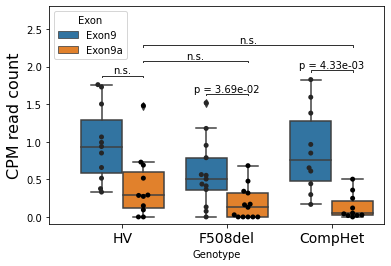

In [129]:
ax = sns.boxplot(data=data, x="group", y="cpm", hue="Exon")
sns.swarmplot(data=data, x="group", y="cpm", hue="Exon", dodge=True, ax=ax, color="black")
h, l = ax.get_legend_handles_labels()
ax.legend(h[:2], l[:2], title="Exon", loc="upper left")
ax.set_ylabel("CPM read count", fontsize=16)
ax.set_xlabel("Genotype")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

test_results = statannot.add_stat_annotation(
    ax, 
    data=data, 
    x="group", 
    y="cpm", 
    hue="Exon",
    box_pairs=[
        (("HV", "Exon9a"), ("F508del", "Exon9a")),
        (("HV", "Exon9a"), ("CompHet", "Exon9a")),
        (("HV", "Exon9"), ("HV", "Exon9a")),
        (("F508del", "Exon9"), ("F508del", "Exon9a")),
        (("CompHet", "Exon9"), ("CompHet", "Exon9a")),
    ],
    test="t-test_ind",
    text_format='simple',
    pvalue_format_string="{:.2e}",
    loc='inside', verbose=2, linewidth=1, 
    line_offset_to_box=0.05, text_offset=0.01, 
    line_offset=0.04, line_height=0.01,
    pvalue_thresholds=[[1e-5, ""]]
)

# Find all comparisons added by stat_annot
n_annots = 0
annot_idx = None
for i, x in enumerate(ax.get_children()):
    if isinstance(x, mpl.text.Annotation):
        annot_text = x.get_text()
        if re.match(r"p = ", annot_text):
            n_annots += 1
            if annot_idx is None:
                annot_idx = i

# Find not significant ones and mark their indices for removal
to_del = []
for i in range(n_annots):
    this_idx = annot_idx + i
    line_idx = annot_idx - n_annots + i
    annot = ax.get_children()[this_idx]
    p_val = float(annot.get_text().split("=")[1].strip())
    if p_val >= 0.05:
        to_del.append(this_idx)
        to_del.append(line_idx)
        annot.set_text("n.s.")

# Remove not significant comparisons and their brackets
# for idx in sorted(to_del, reverse=True):
#     ax.get_children()[idx].remove()


ax.set_xlim(ax.get_xlim()[0] - 0.2, ax.get_xlim()[1])
ax.set_ylim(ax.get_ylim()[0], 2.8)
ax.figure.savefig("07short_ace2.pdf")

Plot Exon CPM counts by k-means cluster and genotype

CF (cl. A)_Exon9 v.s. CF (cl. A)_Exon9a: t-test independent samples with Bonferroni correction, P_val=6.658e-02 stat=2.902e+00
HV (cl. A)_Exon9 v.s. HV (cl. A)_Exon9a: t-test independent samples with Bonferroni correction, P_val=7.762e-02 stat=2.799e+00
CF (cl. B)_Exon9 v.s. CF (cl. B)_Exon9a: t-test independent samples with Bonferroni correction, P_val=5.697e-01 stat=1.938e+00
CF (cl. C)_Exon9 v.s. CF (cl. C)_Exon9a: t-test independent samples with Bonferroni correction, P_val=3.077e-02 stat=3.498e+00
HV (cl. A)_Exon9a v.s. CF (cl. A)_Exon9a: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.175e+00
HV (cl. A)_Exon9a v.s. CF (cl. B)_Exon9a: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.365e+00
HV (cl. A)_Exon9a v.s. CF (cl. C)_Exon9a: t-test independent samples with Bonferroni correction, P_val=4.337e-01 stat=2.007e+00


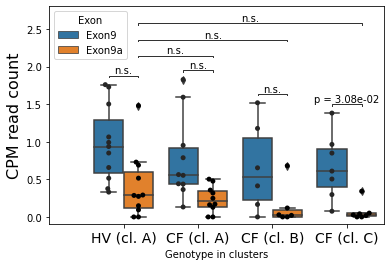

In [132]:
ax = sns.boxplot(data=data2, x="group2", y="cpm", hue="Exon")
sns.swarmplot(data=data2, x="group2", y="cpm", hue="Exon", dodge=True, ax=ax, color="black")
h, l = ax.get_legend_handles_labels()
ax.legend(h[:2], l[:2], title="Exon", loc="upper left")
ax.set_ylabel("CPM read count", fontsize=16)
ax.set_xlabel("Genotype in clusters")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

test_results = statannot.add_stat_annotation(
    ax, 
    data=data2, 
    x="group2", 
    y="cpm", 
    hue="Exon",
    box_pairs=[
        (("HV (cl. A)", "Exon9a"), ("CF (cl. A)", "Exon9a")),
        (("HV (cl. A)", "Exon9a"), ("CF (cl. B)", "Exon9a")),
        (("HV (cl. A)", "Exon9a"), ("CF (cl. C)", "Exon9a")),
        (("HV (cl. A)", "Exon9"), ("HV (cl. A)", "Exon9a")),
        (("CF (cl. A)", "Exon9"), ("CF (cl. A)", "Exon9a")),
        (("CF (cl. B)", "Exon9"), ("CF (cl. B)", "Exon9a")),
        (("CF (cl. C)", "Exon9"), ("CF (cl. C)", "Exon9a")),
    ],
    test="t-test_ind",
    text_format='simple',
    pvalue_format_string="{:.2e}",
    loc='inside', verbose=2, linewidth=1, 
    line_offset_to_box=0.05, text_offset=0.01, 
    line_offset=0.04, line_height=0.01,
    pvalue_thresholds=[[1e-5, ""]]
)

# Find all comparisons added by stat_annot
n_annots = 0
annot_idx = None
for i, x in enumerate(ax.get_children()):
    if isinstance(x, mpl.text.Annotation):
        annot_text = x.get_text()
        if re.match(r"p = ", annot_text):
            n_annots += 1
            if annot_idx is None:
                annot_idx = i

# Find not significant ones and mark their indices for removal
to_del = []
for i in range(n_annots):
    this_idx = annot_idx + i
    line_idx = annot_idx - n_annots + i
    annot = ax.get_children()[this_idx]
    p_val = float(annot.get_text().split("=")[1].strip())
    if p_val >= 0.05:
        to_del.append(this_idx)
        to_del.append(line_idx)
        annot.set_text("n.s.")

# Remove not significant comparisons and their brackets
# for idx in sorted(to_del, reverse=True):
#     ax.get_children()[idx].remove()

ax.set_xlim(ax.get_xlim()[0] - 0.5, ax.get_xlim()[1])
ax.set_ylim(ax.get_ylim()[0], 2.8)
ax.figure.savefig("07short_ace2_clusters.pdf")